In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [73]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [74]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [75]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [76]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [77]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [78]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [79]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [80]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [81]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [82]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [83]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [84]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]

In [85]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    return BCE + KLD

In [86]:
# training
epochs = 10

params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] + [{'params': g.parameters()} for g in Gs]
optimizer = optim.Adam(params, lr=1e-4)

train_loss = 0
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
#         for n in range(len(T1s)):
#             soforth = T1s[n](outputs[n])

#         recon_x = D(soforth)
            
        bits = torch.cat(samples, dim=1)
        q = prob(outputs)
        recon_x = D(bits)
        loss = loss_function(recon_x, x, q)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.824258
Train Epoch: 1 [20000/60000 (33%)]	Loss: 212.043066
Train Epoch: 1 [40000/60000 (67%)]	Loss: 209.960508
====> Epoch: 1 Average loss: 237.4263
Train Epoch: 2 [0/60000 (0%)]	Loss: 200.073711
Train Epoch: 2 [20000/60000 (33%)]	Loss: 210.621973
Train Epoch: 2 [40000/60000 (67%)]	Loss: 200.514531
====> Epoch: 2 Average loss: 435.8400
Train Epoch: 3 [0/60000 (0%)]	Loss: 195.787324
Train Epoch: 3 [20000/60000 (33%)]	Loss: 196.366875
Train Epoch: 3 [40000/60000 (67%)]	Loss: 187.523184
====> Epoch: 3 Average loss: 632.5493
Train Epoch: 4 [0/60000 (0%)]	Loss: 201.939668
Train Epoch: 4 [20000/60000 (33%)]	Loss: 204.224277
Train Epoch: 4 [40000/60000 (67%)]	Loss: 189.992441
====> Epoch: 4 Average loss: 827.1895
Train Epoch: 5 [0/60000 (0%)]	Loss: 201.836172
Train Epoch: 5 [20000/60000 (33%)]	Loss: 193.780488
Train Epoch: 5 [40000/60000 (67%)]	Loss: 193.960449
====> Epoch: 5 Average loss: 1019.8386
Train Epoch: 6 [0/60000 (0%)]	Loss: 190.596387
Train E

In [87]:
q

Variable containing:
( 0 ,.,.) = 
  9.9877e-01  1.2263e-03
  7.4618e-01  2.5382e-01
  9.2268e-01  7.7323e-02
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  2.0285e-03  9.9797e-01
  6.8748e-01  3.1252e-01
  1.1649e-01  8.8351e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  9.9999e-01  8.8939e-06
  9.9998e-01  1.5729e-05
  1.4069e-03  9.9859e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  3.9428e-01  6.0572e-01
  4.5401e-05  9.9995e-01
  7.7463e-02  9.2254e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

(98 ,.,.) = 
  9.8714e-01  1.2857e-02
  6.3543e-01  3.6457e-01
  9.2899e-01  7.1006e-02
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

(99 ,.,.) = 
  9.1491e-01  8.5087e-02
  5.8413e-02  9.4159e-01
  4.6216e-01  5.3784e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
[torch.FloatTensor of size 100x5x2]

In [88]:
bits

Variable containing:
    1     1     1     1     1
    0     1     0     0     0
    1     1     0     0     0
    1     1     1     0     1
    1     1     0     0     1
    0     1     0     0     0
    1     1     0     1     1
    1     1     1     0     1
    1     1     0     1     0
    1     0     1     0     1
    1     0     0     1     0
    1     1     1     1     0
    1     0     1     1     1
    0     1     0     0     1
    0     0     0     1     1
    1     1     0     0     1
    0     1     1     0     0
    1     0     1     1     1
    0     0     1     1     0
    0     1     1     0     1
    1     1     1     0     0
    1     1     0     0     1
    1     1     0     0     0
    1     1     0     0     0
    1     1     0     1     1
    1     1     1     0     0
    0     0     1     0     1
    1     1     0     0     0
    0     0     1     0     1
    1     1     0     1     1
    0     1     0     0     0
    1     0     1     0     1
    1     1     0  

In [19]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [20]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

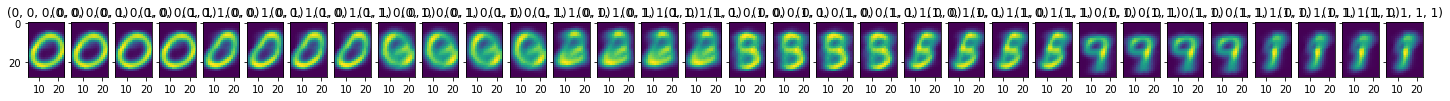

In [89]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
k = 0
for path in product(range(2), repeat=N):
    w = D.forward(Variable(torch.Tensor(path).type(torch.FloatTensor)))
    ax = axes[k]
    ax.set_title(path)
    ax.imshow(w.view(28,28).data.numpy())
    k += 1